In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import numpy as np
import seaborn as snsb

## Pre Defined Functions

In [67]:
def differential(G, beta, alpha, time, init_infected, nodes):
    A = nx.adjacency_matrix(G).todense()
    print(A.shape)
    s = np.zeros((nodes, time+1))
    i = np.zeros((nodes, time+1))
    r = np.zeros((nodes, time+1))

    s[:, 0] = 1 - (init_infected/nodes)
    i[:, 0] = init_infected/nodes
    r[:, 0] = 0 
    t=0
    for t in range(time):
        s[:, t+1:t+2] = s[:, t:t+1] - beta*np.multiply(s[:, t:t+1], A@i[:, t:t+1])*(1)
        i[:, t+1:t+2] = i[:, t:t+1] + beta*np.multiply(s[:, t:t+1], A@i[:, t:t+1])*(1) - alpha*i[:, t:t+1]*(1)
        r[:, t+1:t+2] = r[:, t:t+1] + alpha*i[:, t:t+1]*(1)
    
    return s, i, r

In [3]:
def get_node_data(result, node_index):
    num_simulations = result.shape[0]
    node_data = result[:, :, node_index]
    infected = np.array([np.sum(col==1) for col in node_data.T])/num_simulations
    susceptible = np.array([np.sum(col==0) for col in node_data.T])/num_simulations
    recovered = np.array([np.sum(col==2) for col in node_data.T])/num_simulations
    return susceptible, infected, recovered

In [4]:
def plot(G, t):    
    plt.figure(figsize = (4,4))
    colors = []
    for x in nx.get_node_attributes(G,'state').values():
        if(x==1):
            colors.append('red')
        elif(x==0):
            colors.append('blue')
        else:
            colors.append('green')
    
    nx.draw(G, pos = nx.planar_layout(G), with_labels=True, node_size = 500, \
             node_color = colors, font_color='white', font_size=20)
    plt.title("time = %0.f"%t)
    plt.show()

In [5]:
def simulate(beta, alpha, times, G, display=False): 
    
    states = [list(nx.get_node_attributes(G,'state').values())]
    for t in range(times):
        if(display):
            plot(G, t)
        inf_nodes = [x for x, y in G.nodes.data() if y['state']==1]
        for infected in inf_nodes:
            # infect a neighbor
            susc_neighbors = [x for x, y in G.nodes.data() if y['state']==0 and x in list(G[infected])]
            for neighbor in susc_neighbors:
                if(np.random.rand() < beta):
                    nx.set_node_attributes(G, {neighbor : {'state': 1}})
            
            # recover self
            if(np.random.rand() < alpha):
                nx.set_node_attributes(G, {infected : {'state': 2}})

        states.append(list(nx.get_node_attributes(G,'state').values()))
    return states

## Generate a random network

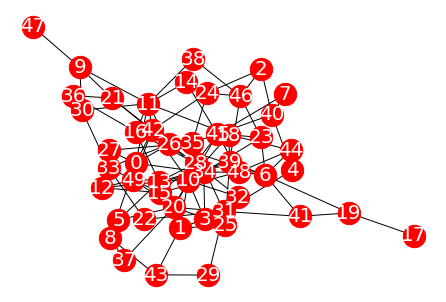

In [95]:
nodes = 50
G = nx.random_graphs.erdos_renyi_graph(nodes, 0.1)
nx.draw(G, pos = nx.spring_layout(G), with_labels=True, node_size = 500, node_color = 'red', font_color='white', font_size=20)

## Monte Carlo Simulation

In [96]:
num_simulations = 100
time = 50
init_infected = 1
beta = 0.3 #infection probability
alpha = 0.1 #recovery rate

list_of_states = [1]*init_infected + [0]*(nodes-init_infected)
np.random.shuffle(list_of_states)
init_states = dict(enumerate(list_of_states))
nx.set_node_attributes(G, init_states, name='state')
    
result = np.zeros((num_simulations, time+1, nodes))
for sim in range(num_simulations):
    states = simulate(beta, alpha, time, G.copy())
    result[sim, :, :] = np.array(states, dtype=np.object)
print(result.shape)

(100, 51, 50)


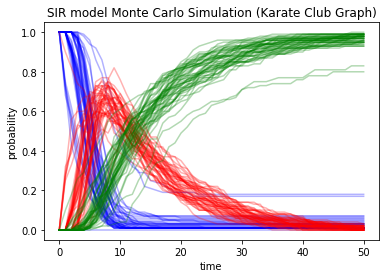

In [97]:
S, I, R = np.zeros((nodes, time+1)), np.zeros((nodes, time+1)), np.zeros((nodes, time+1))
plt.figure()
for node in G.nodes:
    s, i, r = get_node_data(result, node)
    S[node], I[node], R[node] = s, i, r
plt.plot(S.T, 'b-', alpha = 0.3)
plt.plot(I.T, 'r-', alpha = 0.3)
plt.plot(R.T, 'g-', alpha = 0.3)

plt.title("SIR model Monte Carlo Simulation (Erdos Renyi Graph)")
plt.ylabel("probability")
plt.xlabel("time")
plt.savefig("SIR_erdos.png", dpi = 300)

In [98]:
S, I, R = np.zeros((time+1, 1)), np.zeros((time+1, 1)), np.zeros((time+1, 1))
for t in range(time+1):
    S[t] = np.sum([np.sum(nodes==0) for data in result[:,t,:] for nodes in data])/num_simulations
    I[t] = np.sum([np.sum(nodes==1) for data in result[:,t,:] for nodes in data])/num_simulations
    R[t] = np.sum([np.sum(nodes==2) for data in result[:,t,:] for nodes in data])/num_simulations


## Differential Equations

(50, 50)


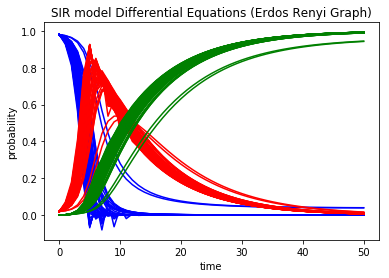

In [99]:
s, i, r= differential(G, beta, alpha, time, init_infected, nodes)

plt.figure()
plt.plot(s.T, c = 'b')
plt.plot(i.T, c = 'r')
plt.plot(r.T, c = 'g')
plt.title("SIR model Differential Equations (Erdos Renyi Graph)")
plt.ylabel("probability")
plt.xlabel("time")
plt.savefig("SIR_erdos_diff.png", dpi = 300)
plt.show()

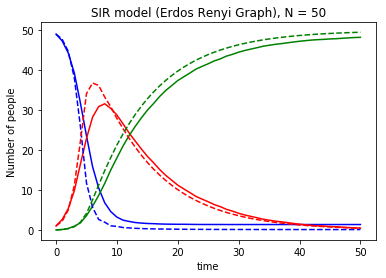

In [100]:
plt.figure()
plt.plot(np.mean(S, axis = 1), c = 'b')
plt.plot(np.mean(I, axis = 1), c = 'r')
plt.plot(np.mean(R, axis = 1), c = 'g')

plt.plot(np.sum(s, axis = 0), 'b--')
plt.plot(np.sum(i, axis = 0), 'r--')
plt.plot(np.sum(r, axis = 0), 'g--')

plt.title("SIR model (Erdos Renyi Graph), N = %0.f"%nodes)
plt.ylabel("Number of people")
plt.xlabel("time")
# plt.legend(loc = 0)
plt.savefig("Comparison_erdos.png", dpi=300)
plt.show()

